## LIBRERIAS

In [ ]:
import shutil
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.applications import  InceptionV3
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.applications import  InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input

## CARGAMOS BASE DE DATOS

In [ ]:
file_imagenes='/content/drive/MyDrive/imagenes_comprimidasBASE_KDM.npz'
file_outputs = '/content/drive/MyDrive/outputsBASE_KDM.npz'
MS = np.load(file_imagenes)['data']
outputs = np.load(file_outputs)['data']
print(MS.shape,outputs.shape)

(60000, 224, 224, 3) (60000, 6)


In [ ]:
# Calcular el mínimo y máximo global de las imágenes
global_vmin = np.min([np.min(img) for img in MS])
global_vmax = np.max([np.max(img) for img in MS])

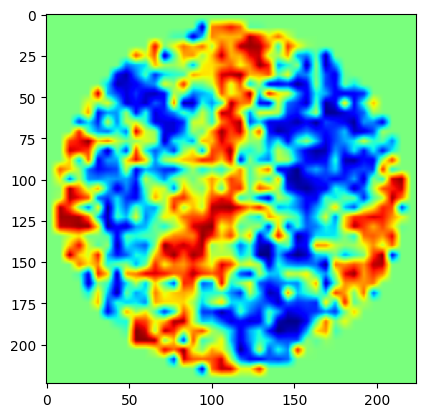

In [ ]:
plt.imshow(MS[1000,:,:,0],cmap='jet',vmin=global_vmin,vmax=global_vmax)

## DISTRIBUIMOS EL DATASET

In [ ]:
# 1. Dividir los datos en entrenamiento, validación y prueba
X_train, X_val, y_train, y_val = train_test_split(MS[:50000],outputs[:50000,:2], test_size=0.2, random_state=42)
del MS, outputs
# 2. Aplicar MinMaxScaler a y_train, y_val, y_test
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.transform(y_val)

# 3. Crear `tf.data.Dataset` y dividir en lotes
batch_size = 64

# Función para convertir numpy arrays en Dataset
def create_tf_dataset(X, y):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = dataset.shuffle(len(X)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Crear datasets en lotes
train_dataset = create_tf_dataset(X_train, y_train_scaled)
val_dataset = create_tf_dataset(X_val, y_val_scaled)

In [ ]:
del X_train, X_val, y_train, y_val,y_train_scaled,y_val_scaled

## MODELO MULTIVARIADO

In [ ]:
# Definir la entrada con la forma correcta (224, 224, 3)
input_layer = Input(shape=(224, 224, 3))

# Cargar el modelo base de DenseNet121 sin la parte superior
base_model =  InceptionV3(weights='imagenet', include_top=False, input_tensor=input_layer)

# Extraer características con GlobalAveragePooling
x = GlobalAveragePooling2D()(base_model.output)

# Capa densa para regresión (1 salida continua)
output_layer = Dense(2, activation='linear')

# Apply the output layer to the previous tensor 'x' to get the output KerasTensor
outputs = output_layer(x) # This line is changed

# Definir el modelo final
# Use 'outputs' instead of 'output_layer'
model = Model(inputs=input_layer, outputs=outputs) # This line is changed

# Compilar el modelo con una pérdida adecuada para regresión
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Mostrar resumen del modelo
model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 111, 111,  │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 111, 111,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 109, 109,  │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 109, 109,  │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 109, 109,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 54, 54,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 54, 54,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 54, 54,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 52, 52,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 52, 52,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 52, 52,    │          0 │ batch_normalizat

 Total params: 21,806,882 (83.19 MB)

 Trainable params: 21,772,450 (83.06 MB)

 Non-trainable params: 34,432 (134.50 KB)

## ENTRENAMIENTO DEL MODELO

In [ ]:
import torch
torch.cuda.empty_cache()  # Si usas PyTorch

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
tf.config.run_functions_eagerly(False)

In [ ]:
# Definir hiperparámetros
epochs = 9  # Número de épocas
batch_size = 16  # Ya definido en la creación del dataset

# Entrenar el modelo
history = model.fit(
    train_dataset,  # Dataset de entrenamiento
    validation_data=val_dataset,  # Dataset de validación
    epochs=epochs,  # Número de iteraciones sobre los datos
    verbose=1  # Muestra progreso
)

Epoch 1/9
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 93ms/step - loss: 0.0420 - mae: 0.1043 - val_loss: 0.0216 - val_mae: 0.1063
Epoch 2/9
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0053 - mae: 0.0499 - val_loss: 0.0038 - val_mae: 0.0413
Epoch 3/9
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0040 - mae: 0.0423 - val_loss: 0.0051 - val_mae: 0.0492
Epoch 4/9
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0035 - mae: 0.0400 - val_loss: 0.0092 - val_mae: 0.0602
Epoch 5/9
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0032 - mae: 0.0389 - val_loss: 0.0072 - val_mae: 0.0472
Epoch 6/9
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0031 - mae: 0.0387 - val_loss: 0.0040 - val_mae: 0.0400
Epoch 7/9
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0027 - mae: 0.0348 - val_loss: 0.0079 - val_mae: 0.0499
Epoch 8/9
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 74ms/step - loss: 0.0028 - mae: 0.0355 - val_loss: 0.0163 - val_mae: 0.0687
Epoch 9/9
625/625 ━━━━━━━━━━━━━━━━━━━━ 46s 73ms

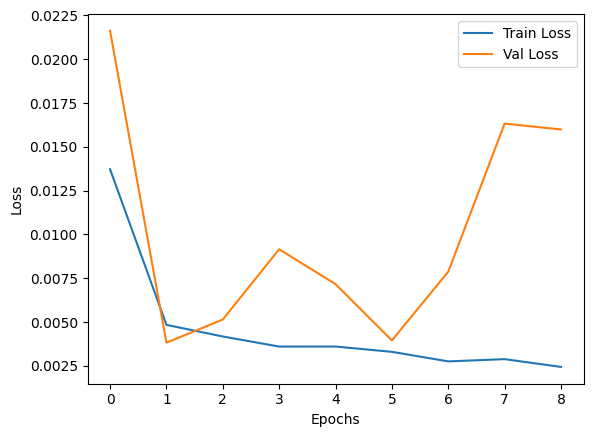

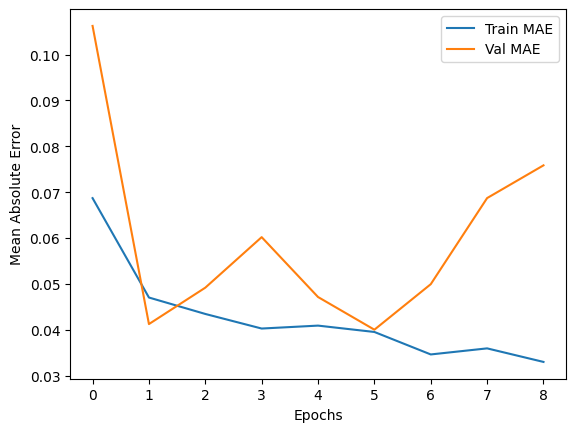

In [ ]:
# Pérdida
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# MAE
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [ ]:

# Obtener las predicciones del modelo
y_pred_list = []
y_real_list = []

# Iterar sobre val_dataset para extraer datos y hacer predicciones en lotes
for batch_x, batch_y in val_dataset:
    y_pred_batch = model.predict(batch_x)  # Predicción del modelo (ahora con 2 salidas)
    y_pred_list.append(y_pred_batch)
    y_real_list.append(batch_y.numpy())  # Convertir tensores a numpy

# Convertir listas a arrays
y_pred = np.concatenate(y_pred_list, axis=0)  # (N, 2)
y_real = np.concatenate(y_real_list, axis=0)  # (N, 2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━

In [ ]:
from sklearn.metrics import r2_score
import numpy as np

def masked_mape(y_true, y_pred, epsilon=1e-8):
    """ MAPE con enmascaramiento para valores cercanos a cero """
    mask = np.abs(y_true) > epsilon  # Evitar dividir por valores cercanos a 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def smape(y_true, y_pred, epsilon=1e-8):
    """ SMAPE con enmascaramiento para valores cercanos a cero """
    denominator = np.abs(y_true) + np.abs(y_pred) + epsilon  # Evitar divisiones por 0
    return np.mean(2 * np.abs(y_true - y_pred) / denominator) * 100

# Calcular métricas por cada salida del modelo
for i in range(y_real.shape[1]):  # Si hay 2 salidas, se hace para cada una
    r2 = r2_score(y_real[:, i], y_pred[:, i])
    mape_value = masked_mape(y_real[:, i], y_pred[:, i])
    smape_value = smape(y_real[:, i], y_pred[:, i])

    print(f"\n📊 **Métricas para la Salida {i+1}**")
    print(f"✅ R² Score: {r2:.4f}")
    print(f"✅ MAPE: {mape_value:.2f}%")
    print(f"✅ SMAPE: {smape_value:.2f}%")


📊 **Métricas para la Salida 1**
✅ R² Score: 0.7103
✅ MAPE: 94.88%
✅ SMAPE: 24.08%

📊 **Métricas para la Salida 2**
✅ R² Score: 0.8576
✅ MAPE: 46.47%
✅ SMAPE: 34.46%


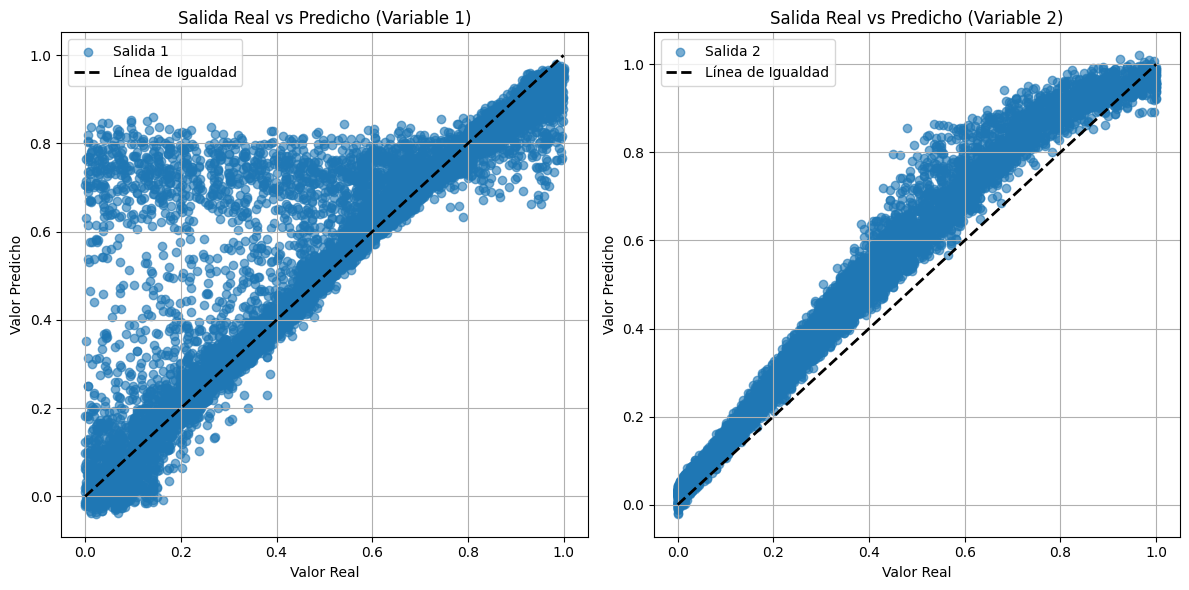

In [ ]:
# Graficar cada salida por separado
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 2 gráficos lado a lado

for i in range(2):  # Para ambas salidas
    axes[i].scatter(y_real[:, i], y_pred[:, i], alpha=0.6, label=f'Salida {i+1}')
    axes[i].plot([min(y_real[:, i]), max(y_real[:, i])],
                 [min(y_real[:, i]), max(y_real[:, i])], 'k--', lw=2, label="Línea de Igualdad")
    axes[i].set_title(f'Salida Real vs Predicho (Variable {i+1})')
    axes[i].set_xlabel('Valor Real')
    axes[i].set_ylabel('Valor Predicho')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
## guardamos los pesos
model.save('/content/drive/MyDrive/DoctoradoPaper1/modelo_Inception_regresionBASE_KDM.h5')  # Guarda en formato HDF5